In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import shapiro
from scipy.stats import ttest_rel, wilcoxon, kruskal

warnings.filterwarnings('ignore')

data = pd.read_csv(r'data\owid-covid-data.csv')

mae = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAE')
maemean = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAEMEAN')
rmse = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='RMSE')
mape = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAPE')
ppe_value = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Value)')
ppe_time = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Time)')

In [49]:
def merge_data(data: pd.DataFrame, error: pd.DataFrame) -> pd.DataFrame:    
    # 計算每個地區的波動性
    results = []  # 用於存儲每個地區的結果
    regions = mape['地區'].tolist()  # 從 MAPE 表獲取地區列表

    for region in regions:
        # 過濾出當前地區的時間序列數據
        region_data = data[data['iso_code'] == region]
        
        # 計算標準差、均值和變異係數（CV）
        std_dev_region = region_data['new_cases_smoothed'].std()
        mean_region = region_data['new_cases_smoothed'].mean()
        cv_region = std_dev_region / mean_region if mean_region != 0 else np.nan
        
        # 將結果添加到列表中
        results.append({
            'Region': region,
            'std_dev': std_dev_region,
            'mean': mean_region,
            'CV': cv_region
        })

    # 轉換為 DataFrame
    volatility_df = pd.DataFrame(results)

    # 2. 合併 MAPE 和波動性數據
    mape_volatility = pd.merge(error, volatility_df, left_on='地區', right_on='Region')

    # 結果展示
    # print(mape_volatility.head())
    return mape_volatility

def classify_volatility(data):
    """根據波動性（CV）劃分高/低波動性區間"""
    threshold = data['CV'].median()
    data['Volatility_Level'] = ['High' if cv > threshold else 'Low' for cv in data['CV']]
    return data

def plot_boxplot(merge_data: pd.DataFrame) -> None:

    # 標記高/低波動性
    classified_data = classify_volatility(merge_data)

    # 繪製整合箱型圖
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # 模型名稱列表
    models = ['ARIMA', 'LSTM', 'SIR']

    # 繪製每個模型的箱型圖
    for i, model in enumerate(models):
        sns.boxplot(
            x='Volatility_Level', 
            y=model, 
            data=classified_data, 
            palette='Set2', 
            ax=axes[i]
        )
        axes[i].set_title(f'{model} MAPE under High/Low Volatility')
        axes[i].set_xlabel('Volatility Level')
        axes[i].set_ylabel('MAPE')

    # 調整佈局
    plt.tight_layout()
    plt.show()

    return classified_data

def paired_test(data, model, group1, group2):
    """ 比較同一模型在兩個區間下的 MAPE 表現 """
    data1 = data[(data['Volatility_Level'] == group1)][model]
    data2 = data[(data['Volatility_Level'] == group2)][model]

    # 檢查是否符合正態分布
    stat1, p1 = shapiro(data1)
    stat2, p2 = shapiro(data2)

    print(f"\n{model} - {group1} vs {group2}")
    if p1 > 0.1 and p2 > 0.1:
        # 使用配對 t 檢定
        stat, p = ttest_rel(data1, data2)
        print(f"Paired t-test: p-value = {p:.4f}")
    else:
        # 使用 Wilcoxon 檢定
        stat, p = wilcoxon(data1, data2)
        print(f"Wilcoxon Test: p-value = {p:.4f}")

    if p < 0.1:
        print("Result: Significant difference between the two groups.")

def compare_models(data, group):
    """ 比較不同模型在同一區間下的 MAPE 表現 """
    data_group = data[data['Volatility_Level'] == group]
    stat, p = kruskal(data_group['ARIMA'], data_group['LSTM'], data_group['SIR'])
    print(f"\nKruskal-Wallis Test for {group} Volatility Level: p-value = {p:.4f}")
    if p < 0.1:
        print("Result: Significant difference between models.")


In [47]:
def pipeline(data: pd.DataFrame, error: pd.DataFrame) -> None:
    """
    Function to run the entire pipeline
    """
    merged_data = merge_data(data, error)
    classified_data = plot_boxplot(merged_data)
    for model in ['ARIMA', 'LSTM', 'SIR']:
        paired_test(classified_data, model, 'High', 'Low')
    compare_models(classified_data, 'High')
    compare_models(classified_data, 'Low')
    

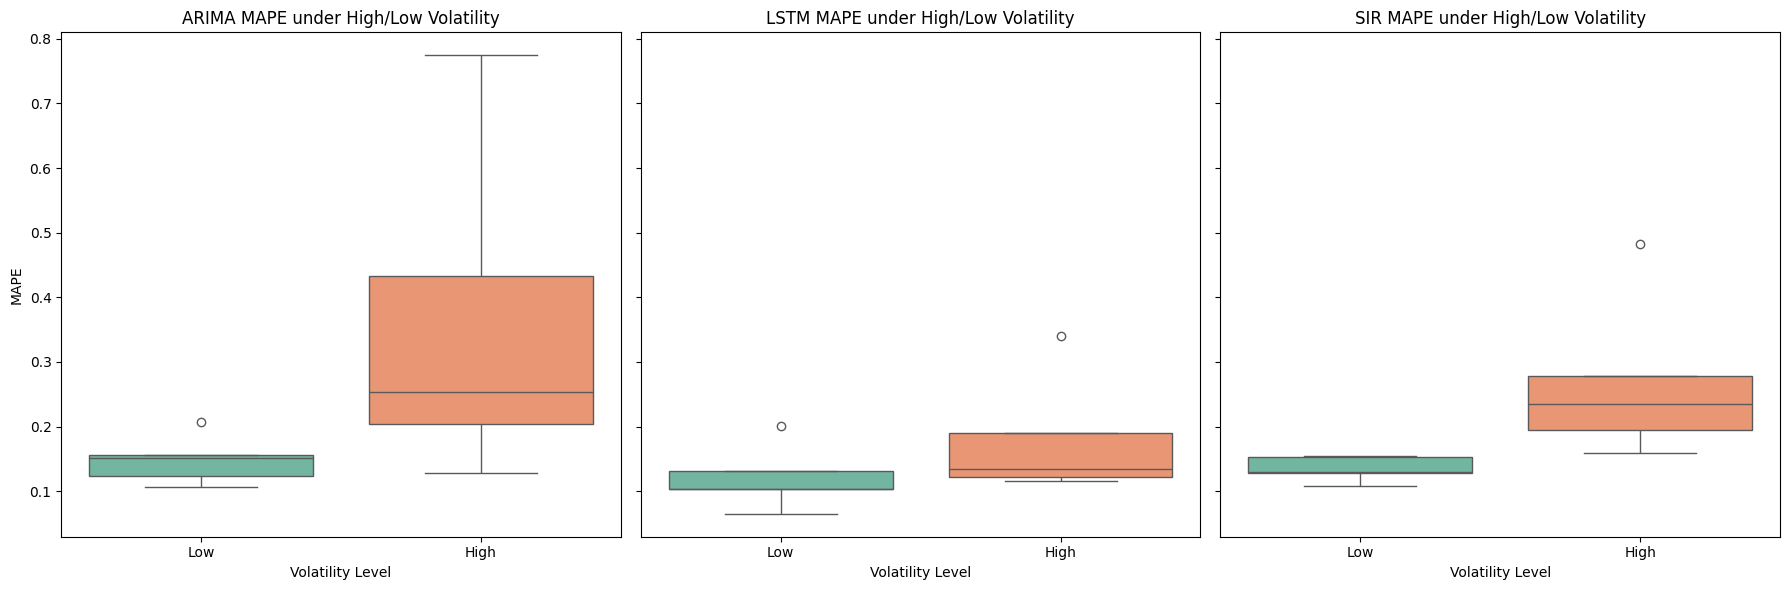


ARIMA - High vs Low
Paired t-test: p-value = 0.1761

LSTM - High vs Low
Wilcoxon Test: p-value = 0.4375

SIR - High vs Low
Paired t-test: p-value = 0.0768
Result: Significant difference between the two groups.

Kruskal-Wallis Test for High Volatility Level: p-value = 0.1809

Kruskal-Wallis Test for Low Volatility Level: p-value = 0.3791


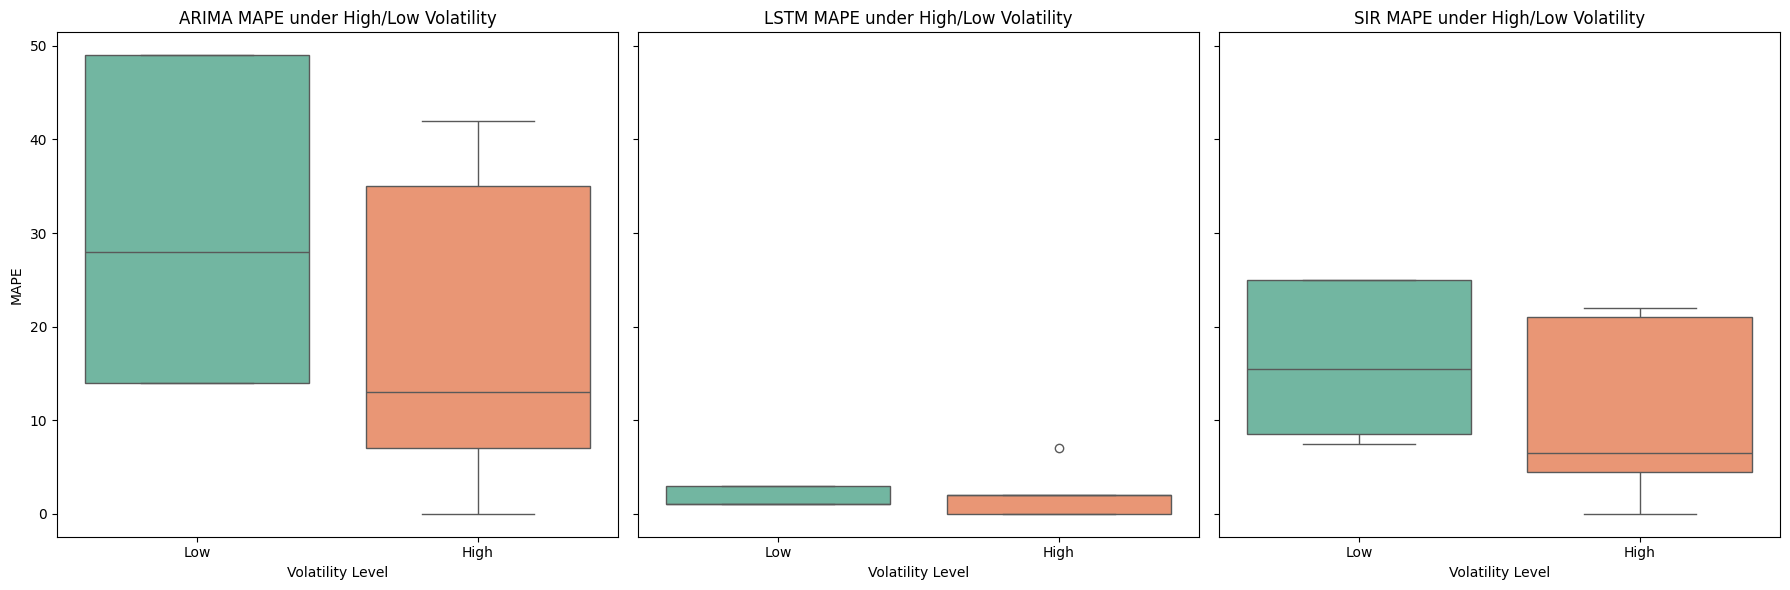


ARIMA - High vs Low
Paired t-test: p-value = 0.3620

LSTM - High vs Low
Wilcoxon Test: p-value = 1.0000

SIR - High vs Low
Paired t-test: p-value = 0.3855

Kruskal-Wallis Test for High Volatility Level: p-value = 0.1585

Kruskal-Wallis Test for Low Volatility Level: p-value = 0.0056
Result: Significant difference between models.


In [48]:
for error in [mape, ppe_time]:
    pipeline(data, error)